In [1]:
import re
import os
import itertools as its
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import scipy as sp
from pandas.io.pytables import HDFStore
import math
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import numpy as np

In [2]:
from sphandles.sphandle import sphandle

In [3]:
#function to parse old and new data format
def tofread_csv(rawdata):
    #read csv file.
    data = pd.read_csv(rawdata, error_bad_lines=False)
    #rennaming 1st column as ID
    data = data.rename(index=str, columns={"Unnamed: 0": "ID"})
    #drop columns that have volume and size
    data = data[data.columns.drop(list(data.filter(regex='vol')))]
    data = data[data.columns.drop(list(data.filter(regex='size')))]
    data.columns = data.columns.str.replace('_mass_g','')
    return data

#parse file name with csv pattern
def parse_filename(fname):
    pattern = ".*__(\w+).csv"
    m = re.match(pattern, fname)
    return m.group(1)

#function to get label and dataframe for old data format
def read_csv(fname,dropcols=None):
    dropcols = dropcols if dropcols else []
    label = parse_filename(fname)
    df = pd.read_csv('./{}'.format(fname),
                    index_col=0)
    df = df[[c for c in df.columns if c.endswith('mass_g') and c not in dropcols]].fillna(0.0)
    df.columns = df.columns.str.replace('_mass_g','')
    df = df[abs(df).T.sum() > 0].reset_index(drop=True)
    df[df < 0] = 0
    df['label'] = label
    df = df.set_index('label')
    return df, label

#isotope_pure returns a data frame of the selected isotope particle event and its impurities
def isotope_pure(data, isotope):
    obs = data[data[isotope] > 0.0]
    others = obs.drop(columns=isotope)
    pure = others.sum(axis=1) == 0.0
    others = obs[pure]
    return others



#counts the total particles associated to an isotope
#conditional_probabilities returns out of the total selected-isotope particle events, what is the probability it is associated with the list of other isotopes 
def conditional_probabilities(data, isotope):
    obs = data[abs(data[isotope]) > 0.0]
    partners = (abs(obs) > 0.0).astype(np.float64).mean()
    return partners[abs(partners) > 0.0].sort_values(ascending=False)

In [4]:
DROPCOLS = ['23Na_mass_g', '27Al_mass_g', '28Si_mass_g', '31P_mass_g', '32S_mass_g', '34S_mass_g', '39K_mass_g', '40Ca_mass_g', '44Ca_mass_g',
            '78Se_mass_g', '80Se_mass_g', '56Fe_mass_g', '87Rb_mass_g', '238U_mass_g']

#incorporate select elements
ELEMENTS1 = ['24Mg', '48Ti', '52Cr', '55Mn', '54Fe', '59Co', '58Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '130Te', '133Cs', '138Ba', '139La', '140Ce', '141Pr', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '181Ta', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb']
#import samples individually
L22 = []
LUV = []
ARZ = []
for i in glob.glob('sample_data/8_19_19/All_Quantified__22*'):
    L22.append(sphandle.read_csv(i, dropcols = DROPCOLS))
for i in glob.glob('sample_data/8_19_19/All_Quantified__Fr*'):
    LUV.append(sphandle.read_csv(i, dropcols = DROPCOLS))
for i in glob.glob('sample_data/8_19_19/All_Quantified__Az*'):
    ARZ.append(sphandle.read_csv(i, dropcols = DROPCOLS))


# get the conditional probabilities for each sample
L22probab = []
LUVprobab = []
ARZprobab = []


for i in np.arange(0,len(L22)):
    L22probab.append(sphandle.conditional_probabilities(L22[i][0][ELEMENTS1], '48Ti'))
    LUVprobab.append(sphandle.conditional_probabilities(LUV[i][0][ELEMENTS1], '48Ti')) 
    ARZprobab.append(sphandle.conditional_probabilities(ARZ[i][0][ELEMENTS1], '48Ti'))

#compile them into a dataframe
L22avg = pd.DataFrame([i for i in L22probab]).fillna(0).T
LUVavg = pd.DataFrame([i for i in LUVprobab]).fillna(0).T
ARZavg = pd.DataFrame([i for i in ARZprobab]).fillna(0).T

#adding Label column
L22avg['Label'] = 'Ti-NNMs in L22'
LUVavg['Label'] = 'Ti-NNMs in LUV'
ARZavg['Label'] = 'Ti-NNMs in ARZ'


#import samples individually
Tiobs1, obs = sphandle.read_csv('sample_data/6_07_19/All_Quantified__67Tiobs16.csv', dropcols=DROPCOLS)
Tiobs2, obs = sphandle.read_csv('sample_data/4_12_19/All_Quantified__Tiobs5.csv', dropcols=DROPCOLS)
Tiobs3, obs = sphandle.read_csv('sample_data/4_12_19/All_Quantified__Tiobs3.csv', dropcols=DROPCOLS)
Ti100 = [Tiobs1, Tiobs2, Tiobs3]

newSludge = []
for i in glob.glob('sample_data/8_24_20/particle_masses_Sludge*'):
    print(i)
    newSludge.append(sphandle.tofread_csv(i))

#modify columns from new data format
for i in newSludge:
    i.drop(columns = ['Index', 'timestamp /s'], inplace = True)
    i.columns = i.columns.str.replace(r' /g', '')
    i.columns = i.columns.str.replace(r'[', '')
    i.columns = i.columns.str.replace('+', '')
    i.columns = i.columns.str.replace(']', '')

#drop columns
for i in newSludge:
    i.drop(columns = ['27Al', '47Ti', '49Ti', '28Si', '137Ba'], inplace = True)
conditionalTi = []
for i in newSludge:
    conditionalTi.append(sphandle.conditional_probabilities(i, '48Ti'))


Ti30nm1, Ti30l = read_csv('sample_data/8_19_19/All_Quantified__30nm2.csv',  dropcols=DROPCOLS)
Ti30nm2, Ti30l = read_csv('sample_data/8_19_19/All_Quantified__30nm1.csv',  dropcols=DROPCOLS)
Ti30nm3, Ti30l = read_csv('sample_data/8_19_19/All_Quantified__30nm3.csv',  dropcols=DROPCOLS)
Ti30 = [Ti30nm1, Ti30nm2, Ti30nm3]

# get the conditional probabilities for each sample
Ti100probab = []
Sludgeprobab = []
Ti30probab = []
 
ELEMENTS2 = ['24Mg', '48Ti', '52Cr', '55Mn', '59Co', '58Ni', '63Cu', '64Zn', '69Ga', '75As', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '130Te', '138Ba', '139La', '140Ce', '141Pr', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '181Ta', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb']


for i in np.arange(0,len(Ti100)):
    Ti100probab.append(sphandle.conditional_probabilities(Ti100[i][ELEMENTS2], '48Ti'))
    Ti30probab.append(sphandle.conditional_probabilities(Ti30[i][ELEMENTS2], '48Ti'))

for i in np.arange(0, len(newSludge)):
    Sludgeprobab.append(conditional_probabilities(newSludge[i][ELEMENTS1], '48Ti')) 


#compile them into a dataframe
Ti100avg = pd.DataFrame([i for i in Ti100probab]).fillna(0).T
Sludgeavg = pd.DataFrame([i for i in Sludgeprobab]).fillna(0).T
Ti30avg = pd.DataFrame([i for i in Ti30probab]).fillna(0).T

#adding Label column
Sludgeavg['Label'] = 'Recovered Ti-NMs in Sludge'

#create the plot data
INDEX1 = ['54Fe', '107Ag', '64Zn', '138Ba', '24Mg', '55Mn', '93Nb', '85Rb', '208Pb', '63Cu', '58Ni', '140Ce', '90Zr', '120Sn', '88Sr']
altogether = pd.concat([L22avg.reindex(INDEX1), LUVavg.reindex(INDEX1), ARZavg.reindex(INDEX1), 
                        Sludgeavg.reindex(INDEX1)
                       ]).reset_index()
snsplotdata = pd.melt(altogether, id_vars = ['index', 'Label'])

sample_data/8_24_20\particle_masses_SludgeA_1fe72b2d-3857-413d-b17b-229f4c8f9210.csv
sample_data/8_24_20\particle_masses_SludgeB_bf6e7c4b-4c7c-437e-b81f-e89874f67d94.csv
sample_data/8_24_20\particle_masses_SludgeC_e08d78f2-63db-4c41-8053-88f7bb1732e2.csv
sample_data/8_24_20\particle_masses_SludgeD_75af73c2-04d2-42f1-976f-101c85574b32.csv
sample_data/8_24_20\particle_masses_SludgeE_5be2202c-fb90-4076-b2b3-07641c5ff98d.csv
sample_data/8_24_20\particle_masses_SludgeF_c474f550-ffd5-4e8f-b955-084ff571599b.csv


<ipython-input-4-08d63d1b35e7>:51: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  newSludge.append(sphandle.tofread_csv(i))
<ipython-input-4-08d63d1b35e7>:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  i.columns = i.columns.str.replace(r'[', '')
<ipython-input-4-08d63d1b35e7>:58: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  i.columns = i.columns.str.replace('+', '')
<ipython-input-4-08d63d1b35e7>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  i.columns 

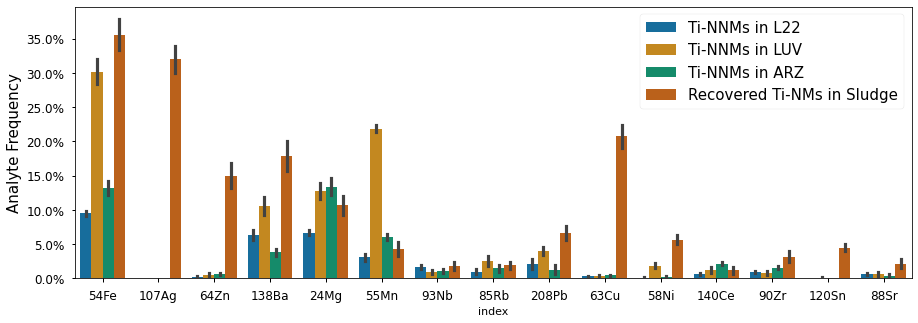

In [5]:
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x = 'index', y = 'value', hue = 'Label', data = snsplotdata, ci = 'sd', palette = "colorblind")
ax.set_ylabel('Analyte Frequency', fontsize = 15)
ax.legend(loc = 'upper right', fontsize = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0)
#ax.set_yscale('log')
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
#plt.savefig('../../figsfromscript/conditionalnaturaltracer.png', dpi = 300)

# Size distribution

In [6]:
store = pd.HDFStore('sample_data/H5 files/alldfsnormalnoAltest.h5')
storeall = [store.Frsl, store.Az, store.L22, store.Frso, store.OBS, store.Ti30nm]

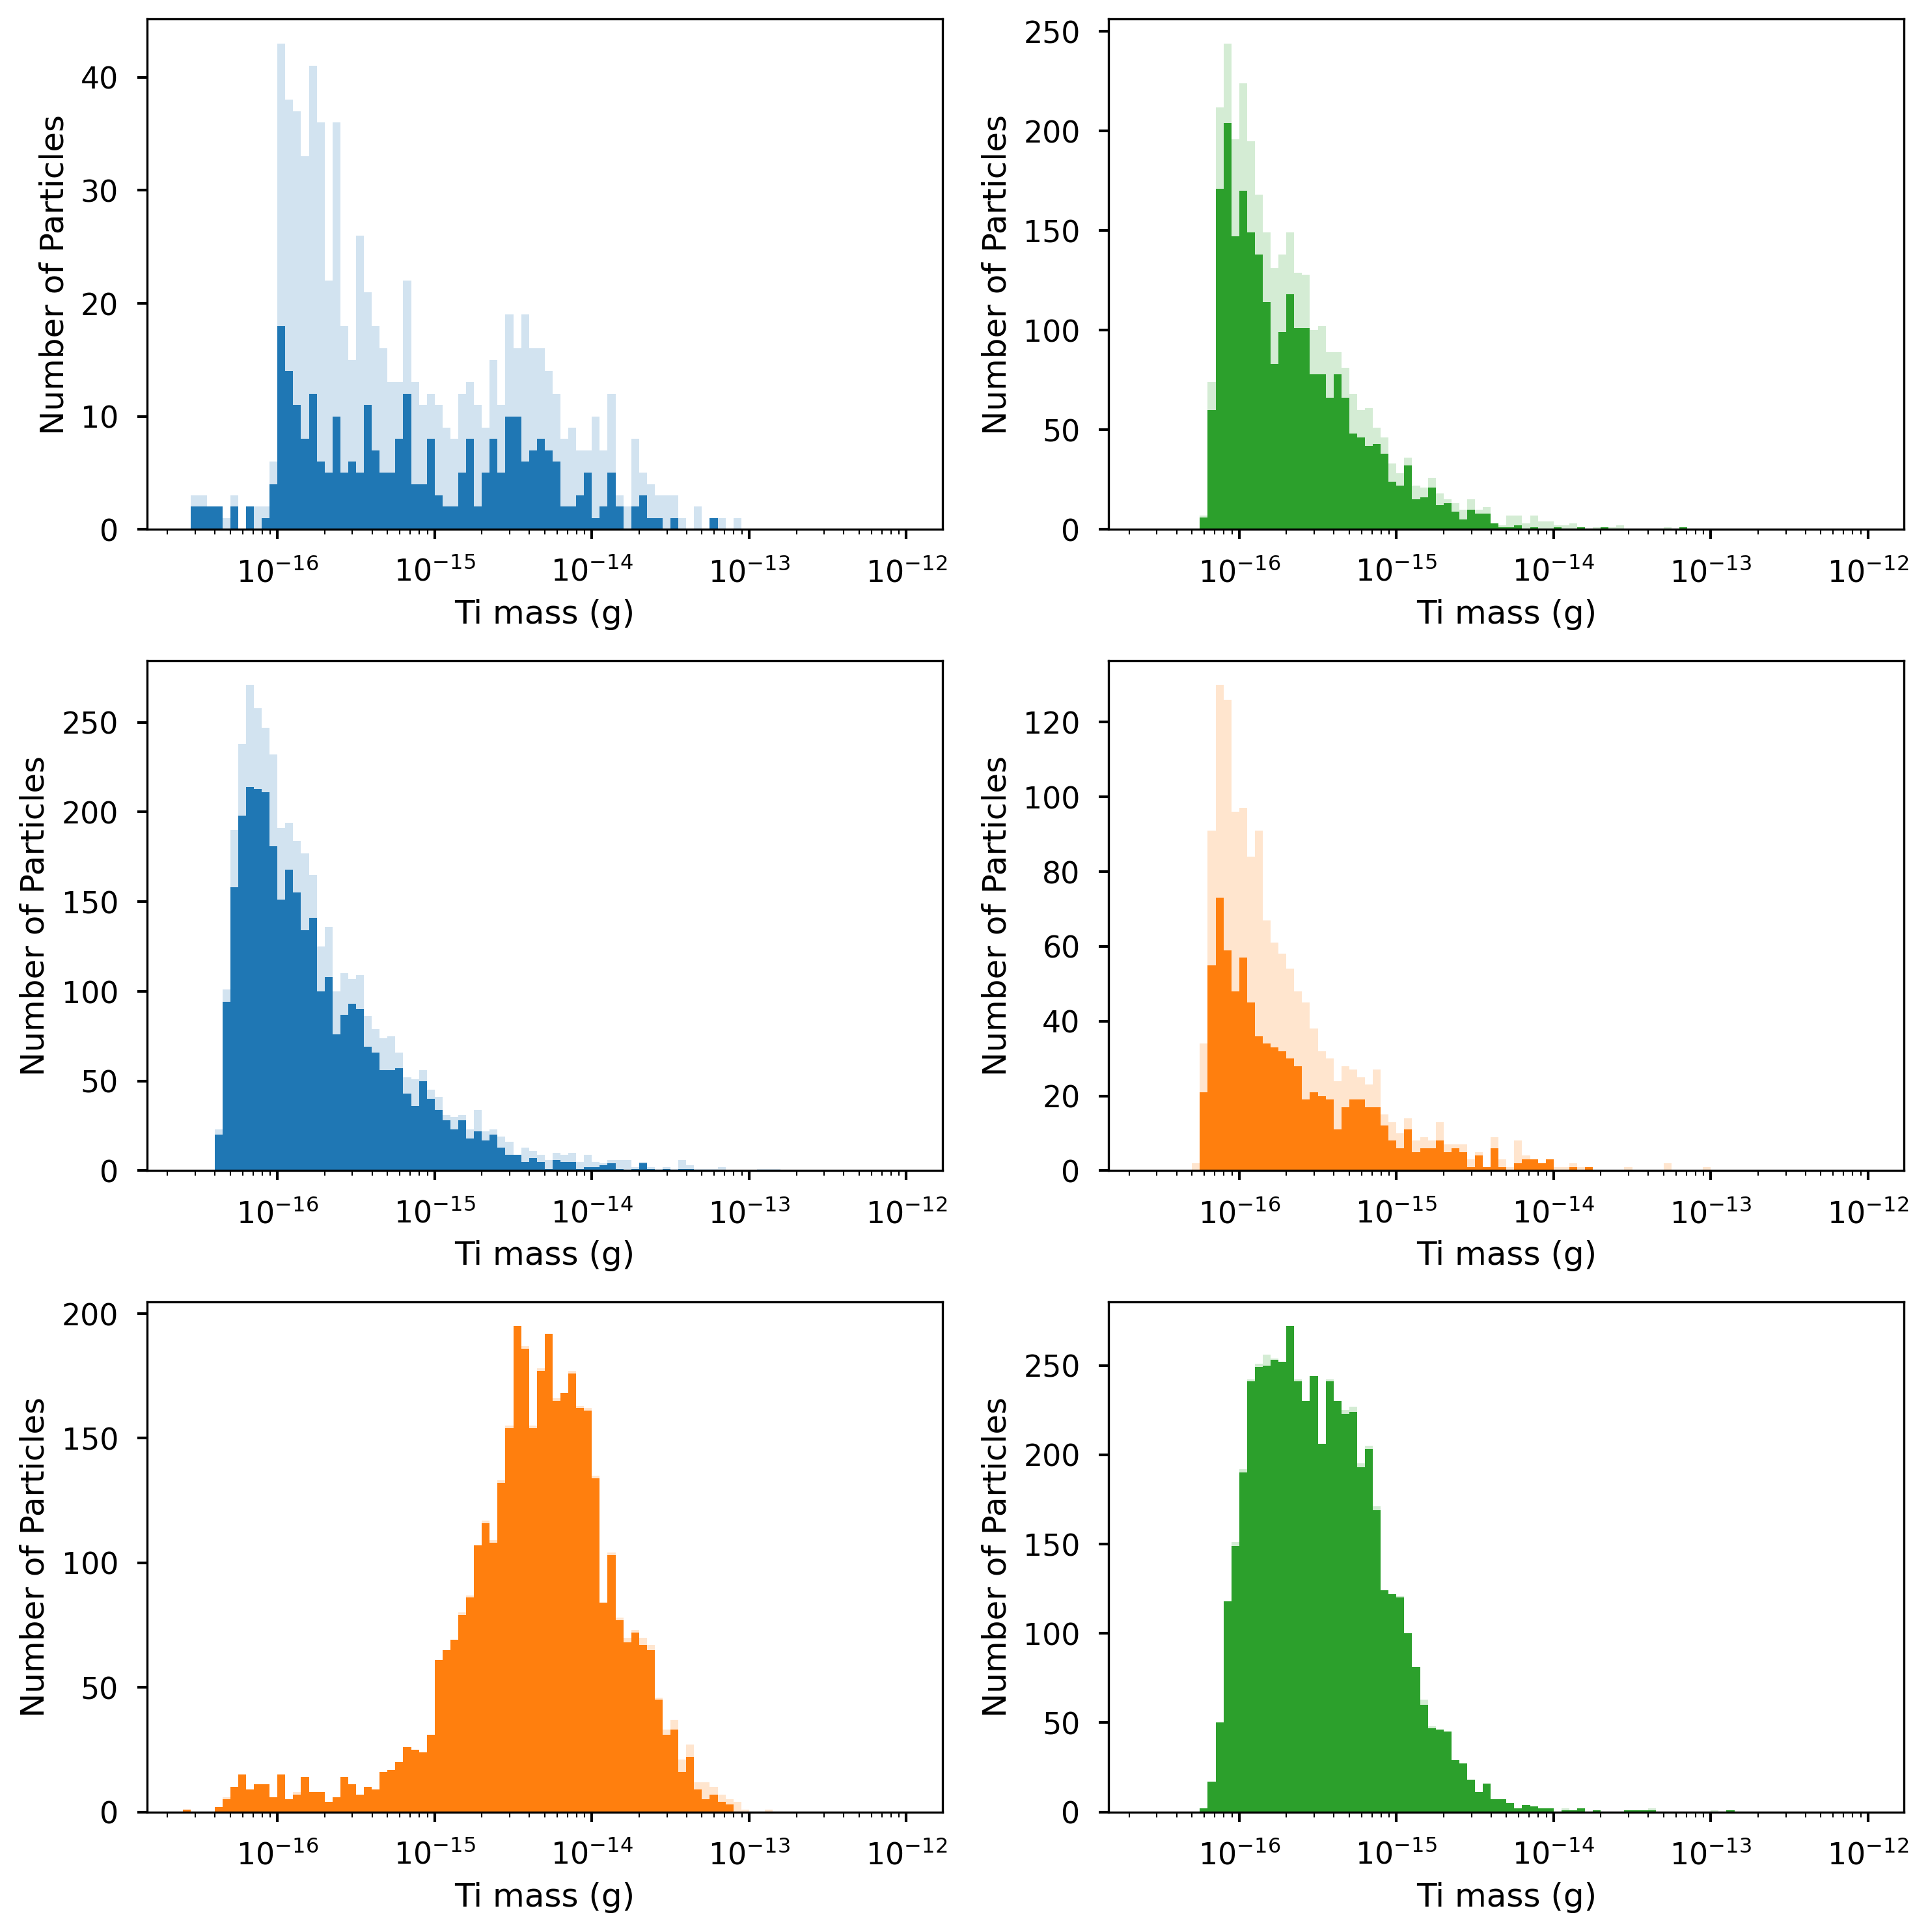

In [7]:
#making graph for Ti mass distribution with an axis log scale
fig, axs = plt.subplots(3, 2, figsize=(10,10), dpi=300)
axs = axs.flatten()
color = ['C0', 'C2', 'C0', 'C1', 'C1', 'C2']
bins = 10**(np.arange(-16.6,-12, .05).astype('float'))
for i in range(0, len(storeall)):
    axs[i].hist(storeall[i]['48Ti'], bins = bins, color = color[i], alpha = 0.2)
    axs[i].hist(sphandle.isotope_pure(storeall[i].drop(columns = '46Ti'), '48Ti')['48Ti'], bins = bins, color = color[i])
    axs[i].tick_params(labelsize = 8)
    axs[i].set_ylabel('Number of Particles', fontsize = 12)
    axs[i].set_xlabel('Ti mass (g)', fontsize = 12)
    axs[i].set_xscale('log')
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.tight_layout()
#plt.savefig('massdistsoils.png', dpi = 300)

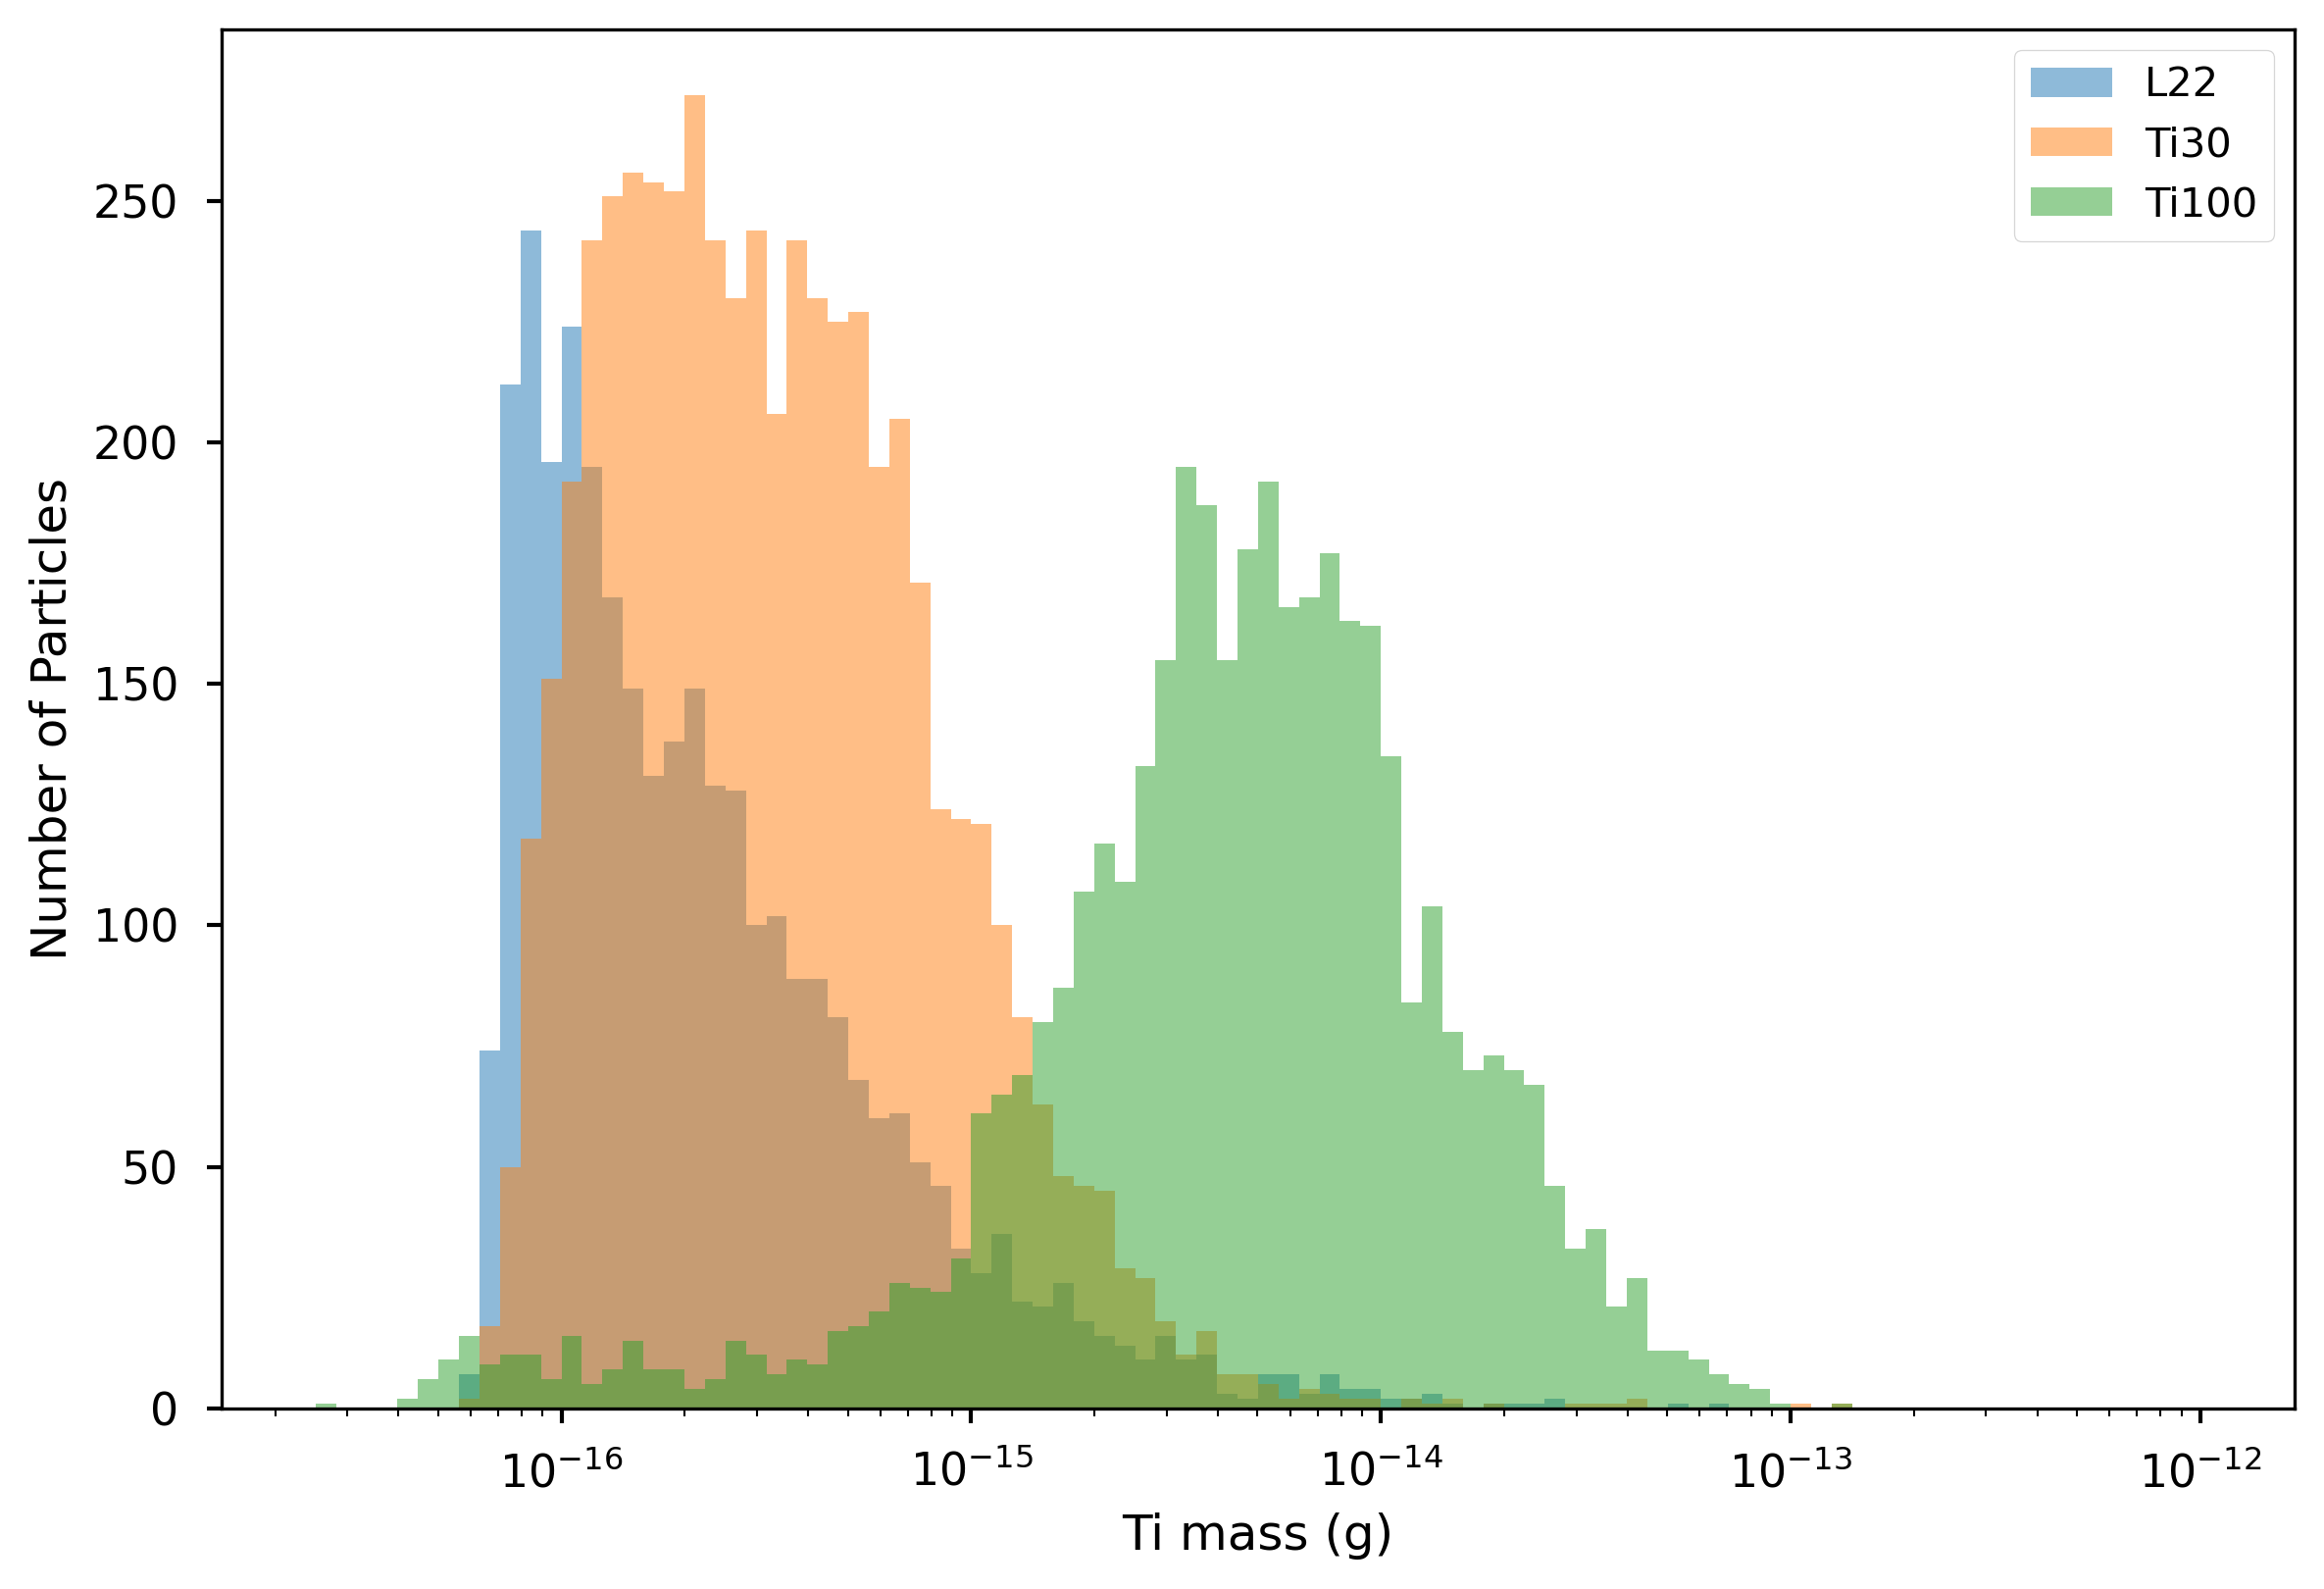

In [8]:
#making graph for Ti mass distribution with an axis log scale
fig, axs = plt.subplots(dpi=300)
#axs = axs.flatten()
#color = ['C0', 'C2', 'C0', 'C1', 'C1', 'C2']
bins = 10**(np.arange(-16.6,-12, .05).astype('float'))
axs.hist(storeall[1]['48Ti'], bins = bins, alpha = 0.5, label = 'L22')
axs.hist(storeall[5]['48Ti'], bins = bins, alpha = 0.5, label = 'Ti30')
axs.hist(storeall[4]['48Ti'], bins = bins, alpha = 0.5, label = 'Ti100')
axs.tick_params(labelsize = 8)
axs.legend()
axs.set_ylabel('Number of Particles', fontsize = 12)
axs.set_xlabel('Ti mass (g)', fontsize = 12)
axs.set_xscale('log')
axs.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.tight_layout()
#plt.savefig('massdistsoils.png', dpi = 300)